In [1]:
# Check GPU availability
import torch
print(f"PyTorch version: {torch.__version__}")
print(f"GPU available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

PyTorch version: 2.9.0+cu126
GPU available: True
GPU: Tesla T4


In [6]:
torch.backends.cudnn.benchmark = True


In [3]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [4]:
!cp -r "/content/drive/MyDrive/archive/OS Collected Data" "/content/data"



In [9]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, random_split
import time
import copy
from tqdm import tqdm
import os
import numpy as np


In [27]:
import matplotlib.pyplot as plt


data_dir = "/content/data"
normal_data = "/content/data/Normal"
osteopenia = "/content/data/Osteopenia"
osteoporosis = "/content/data/Osteoporosis"

# Load dataset
dataset = datasets.ImageFolder(root=data_dir)

print(f"Total images: {len(dataset)}")
print(f"Classes: {dataset.classes}")

Total images: 1947
Classes: ['Normal', 'Osteopenia', 'Osteoporosis']


In [28]:
data_dir = "/content/data"  # after copying from Google Drive
BATCH_SIZE = 16
NUM_EPOCHS = 25
LEARNING_RATE = 0.0001

weights = models.ResNet50_Weights.DEFAULT
base_transform = weights.transforms()

mean = base_transform.mean
std = base_transform.std

train_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])



In [29]:
# Load dataset WITHOUT transform
full_dataset = datasets.ImageFolder(root=data_dir)

# 70/15/15 split
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_data, val_data, test_data = random_split(
    full_dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(123)
)

# Assign transforms AFTER splitting
train_data.dataset.transform = train_transforms
val_data.dataset.transform = val_test_transforms
test_data.dataset.transform = val_test_transforms

print(f"Total images: {len(full_dataset)}")
print(f"Train/Val/Test Split: {len(train_data)} / {len(val_data)} / {len(test_data)}")
print(f"Classes: {full_dataset.classes}")


Total images: 1947
Train/Val/Test Split: 1362 / 292 / 293
Classes: ['Normal', 'Osteopenia', 'Osteoporosis']


In [30]:
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True,
                          num_workers=4, pin_memory=True)
val_loader = DataLoader(val_data, batch_size=BATCH_SIZE, shuffle=False,
                        num_workers=4, pin_memory=True)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False,
                         num_workers=4, pin_memory=True)

/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [31]:
# Load ResNet-50 with ImageNet weights
model_resnet50 = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)

# Unfroze layer4
for name, param in model_resnet50.named_parameters():
    if "layer4" in name:      # Last ResNet block → trainable
        param.requires_grad = True
    else:
        param.requires_grad = False  # Everything else stays frozen

# Replace final fc layer with 3 classes
num_features = model_resnet50.fc.in_features
model_resnet50.fc = nn.Linear(num_features, 3)

# The new FC layer is trainable by default
# Layer4 is also trainable now

# Loss Function
criterion = nn.CrossEntropyLoss()

# Optimizer
optimizer = torch.optim.Adam(
    filter(lambda p: p.requires_grad, model_resnet50.parameters()),
    lr=LEARNING_RATE
)


In [32]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model_resnet50 = model_resnet50.to(device)
print(device)

cuda:0


In [33]:
torch.backends.cudnn.benchmark = True


In [34]:
from torch.cuda.amp import autocast, GradScaler
torch.backends.cudnn.benchmark = True   # faster training on GPU

def train_model(model, criterion, optimizer, num_epochs):
    since = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    scaler = GradScaler()  # mixed precision scaler

    history = {
        "train_loss": [], "train_acc": [],
        "val_loss": [], "val_acc": []
    }

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("-" * 20)

        for phase in ["train", "val"]:
            model.train() if phase == "train" else model.eval()
            dataloader = train_loader if phase == "train" else val_loader

            running_loss = 0.0
            running_corrects = 0

            loop = tqdm(dataloader, desc=f"{phase}", leave=False)

            for inputs, labels in loop:
                inputs, labels = inputs.to(device), labels.to(device)
                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == "train"):
                    with autocast():  # mixed precision
                        outputs = model(inputs)
                        loss = criterion(outputs, labels)
                        _, preds = torch.max(outputs, 1)

                    if phase == "train":
                        scaler.scale(loss).backward()
                        scaler.step(optimizer)
                        scaler.update()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels)

            epoch_loss = running_loss / len(dataloader.dataset)
            epoch_acc = running_corrects.double().item() / len(dataloader.dataset)

            print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}")

            history[f"{phase}_loss"].append(epoch_loss)
            history[f"{phase}_acc"].append(epoch_acc)

            if phase == "val" and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
                print(f"*** New best model: Val Acc = {best_acc:.4f} ***")

    time_elapsed = time.time() - since
    print(f"\nTraining complete in {time_elapsed//60:.0f}m {time_elapsed%60:.0f}s")
    print(f"Best Validation Accuracy: {best_acc:.4f}")

    model.load_state_dict(best_model_wts)
    return model, history


In [35]:
final_model, history = train_model(model_resnet50, criterion, optimizer, num_epochs=25)

/tmp/ipython-input-1532791408.py:9: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()  # mixed precision scaler



Epoch 1/25
--------------------


train:   0%|          | 0/86 [00:00<?, ?it/s]/tmp/ipython-input-1532791408.py:34: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():  # mixed precision


Train Loss: 0.8401 Acc: 0.6182


Val Loss: 0.5521 Acc: 0.7842
*** New best model: Val Acc = 0.7842 ***

Epoch 2/25
--------------------


Train Loss: 0.4534 Acc: 0.8231


Val Loss: 0.4321 Acc: 0.8219
*** New best model: Val Acc = 0.8219 ***

Epoch 3/25
--------------------


Train Loss: 0.2795 Acc: 0.8957


Val Loss: 0.3123 Acc: 0.8870
*** New best model: Val Acc = 0.8870 ***

Epoch 4/25
--------------------


Train Loss: 0.2011 Acc: 0.9214


Val Loss: 0.3263 Acc: 0.8527

Epoch 5/25
--------------------


Train Loss: 0.1720 Acc: 0.9148


Val Loss: 0.3268 Acc: 0.8904
*** New best model: Val Acc = 0.8904 ***

Epoch 6/25
--------------------


Train Loss: 0.1603 Acc: 0.9200


Val Loss: 0.3503 Acc: 0.8801

Epoch 7/25
--------------------


Train Loss: 0.1462 Acc: 0.9317


Val Loss: 0.3774 Acc: 0.8767

Epoch 8/25
--------------------


Train Loss: 0.1449 Acc: 0.9229


Val Loss: 0.3350 Acc: 0.9075
*** New best model: Val Acc = 0.9075 ***

Epoch 9/25
--------------------


Train Loss: 0.1354 Acc: 0.9302


Val Loss: 0.3669 Acc: 0.9041

Epoch 10/25
--------------------


Train Loss: 0.1474 Acc: 0.9244


Val Loss: 0.3560 Acc: 0.8870

Epoch 11/25
--------------------


Train Loss: 0.1202 Acc: 0.9339


Val Loss: 0.3853 Acc: 0.8767

Epoch 12/25
--------------------


Train Loss: 0.1258 Acc: 0.9325


Val Loss: 0.3703 Acc: 0.8664

Epoch 13/25
--------------------


Train Loss: 0.1383 Acc: 0.9273


Val Loss: 0.3291 Acc: 0.9041

Epoch 14/25
--------------------


Train Loss: 0.1264 Acc: 0.9302


Val Loss: 0.3755 Acc: 0.8801

Epoch 15/25
--------------------


Train Loss: 0.1181 Acc: 0.9361


Val Loss: 0.3927 Acc: 0.8938

Epoch 16/25
--------------------


Train Loss: 0.1158 Acc: 0.9354


Val Loss: 0.3661 Acc: 0.8733

Epoch 17/25
--------------------


Train Loss: 0.1075 Acc: 0.9369


Val Loss: 0.4086 Acc: 0.8973

Epoch 18/25
--------------------


Train Loss: 0.1018 Acc: 0.9405


Val Loss: 0.4346 Acc: 0.8938

Epoch 19/25
--------------------


Train Loss: 0.1117 Acc: 0.9354


Val Loss: 0.3889 Acc: 0.9075

Epoch 20/25
--------------------


Train Loss: 0.1200 Acc: 0.9347


Val Loss: 0.4798 Acc: 0.8733

Epoch 21/25
--------------------


Train Loss: 0.1049 Acc: 0.9369


Val Loss: 0.5059 Acc: 0.8801

Epoch 22/25
--------------------


Train Loss: 0.1158 Acc: 0.9339


Val Loss: 0.4329 Acc: 0.8870

Epoch 23/25
--------------------


Train Loss: 0.1078 Acc: 0.9332


Val Loss: 0.4283 Acc: 0.8938

Epoch 24/25
--------------------


Train Loss: 0.1031 Acc: 0.9354


Val Loss: 0.4860 Acc: 0.8870

Epoch 25/25
--------------------


Train Loss: 0.1098 Acc: 0.9347


Val Loss: 0.4892 Acc: 0.9041

Training complete in 2m 31s
Best Validation Accuracy: 0.9075


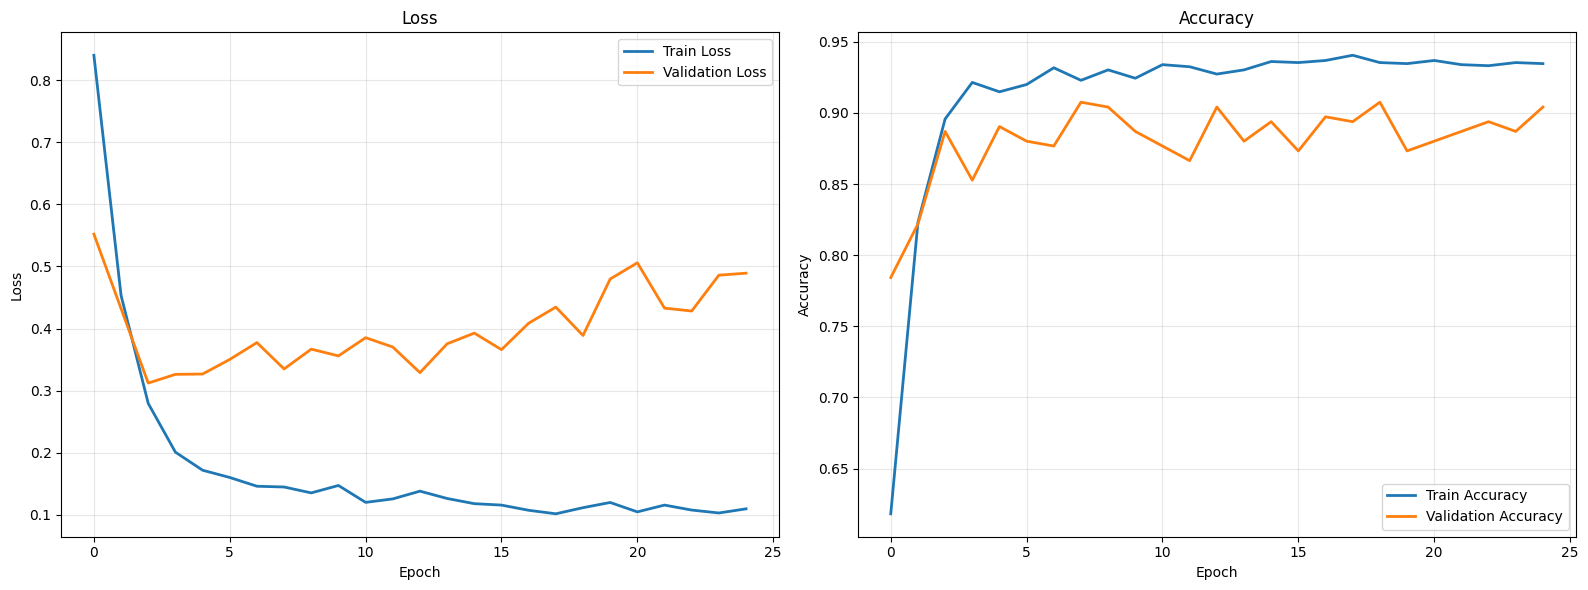

In [36]:
import matplotlib.pyplot as plt
import os

# Create results directory if it doesn't exist
RESULTS_DIR = "results"
os.makedirs(RESULTS_DIR, exist_ok=True)

# Plot training curves
plt.figure(figsize=(16, 6))

# ---- LOSS PLOT ----
plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss', linewidth=2)
plt.plot(history['val_loss'], label='Validation Loss', linewidth=2)
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True, alpha=0.3)
plt.legend()

# ---- ACCURACY PLOT ----
plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Accuracy', linewidth=2)
plt.plot(history['val_acc'], label='Validation Accuracy', linewidth=2)
plt.title("Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.grid(True, alpha=0.3)
plt.legend()

plt.tight_layout()

# Save the figure
plt.savefig(os.path.join(RESULTS_DIR, "training_curves.png"), dpi=150)

plt.show()


In [37]:
# Save entire model state
torch.save(final_model.state_dict(), "resnet50_best_model.pth")
print("Model saved successfully!")


Model saved successfully!


In [38]:
# Load the model if needed
model_resnet50.load_state_dict(torch.load("resnet50_best_model.pth"))
model_resnet50.to(device)
model_resnet50.eval()
print("Model loaded and ready!")


Model loaded and ready!


In [39]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import os

def evaluate_model(model, dataloader, class_names, phase='test'):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)

    accuracy = np.mean(all_preds == all_labels)

    print(f"\n{phase.upper()} ACCURACY: {accuracy:.4f} ({accuracy*100:.2f}%)\n")

    print("Classification Report:")
    print(classification_report(all_labels, all_preds, target_names=class_names, digits=4))

    # ---- Confusion Matrix ----
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names)
    plt.title(f"{phase.upper()} Confusion Matrix")
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.tight_layout()

    os.makedirs(RESULTS_DIR, exist_ok=True)
    plt.savefig(os.path.join(RESULTS_DIR, f"{phase}_confusion_matrix.png"), dpi=150)
    plt.show()

    return accuracy



TEST ACCURACY: 0.8532 (85.32%)

Classification Report:
              precision    recall  f1-score   support

      Normal     0.9052    0.9052    0.9052       116
  Osteopenia     0.7895    0.7143    0.7500        63
Osteoporosis     0.8333    0.8772    0.8547       114

    accuracy                         0.8532       293
   macro avg     0.8427    0.8322    0.8366       293
weighted avg     0.8523    0.8532    0.8522       293



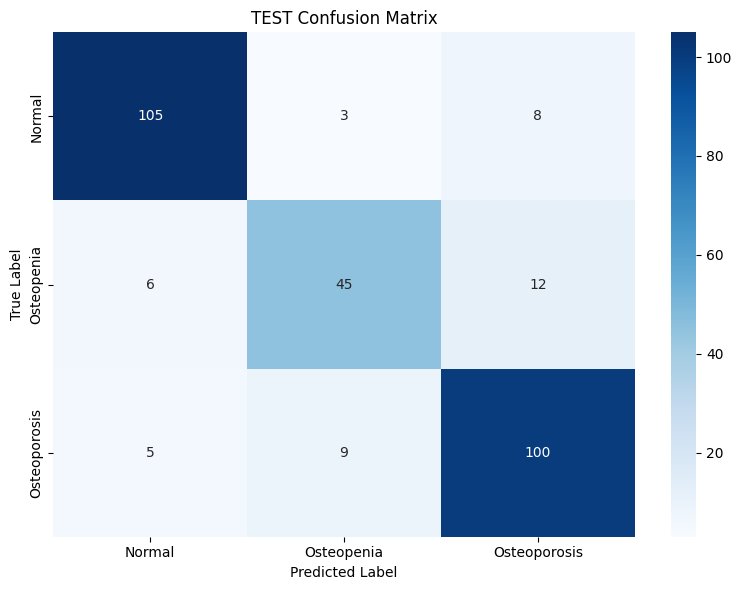

In [40]:
# Run final evaluation
class_names = full_dataset.classes
test_acc = evaluate_model(final_model, test_loader, class_names, phase='test')